In [1]:
import os
import numpy as np
import time
import matplotlib.pyplot as plt
import pandas as pd
import math
import pickle
import statsmodels
from statsmodels.tsa.stattools import coint
import matplotlib.pyplot as plt
import fix_yahoo_finance as yf

[*********************100%***********************]  1 of 1 downloaded


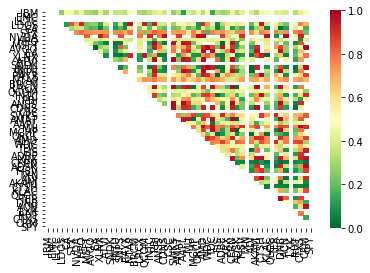

[('CA', 'DNB'), ('MSFT', 'ADBE'), ('AVGO', 'EA'), ('XLNX', 'KLAC'), ('INTU', 'FIS'), ('INTU', 'ADI'), ('SNPS', 'ADI'), ('PAYX', 'FIS'), ('LRCX', 'ADSK'), ('AMAT', 'MCHP'), ('AMAT', 'ADSK'), ('MCHP', 'ADSK'), ('ORCL', 'FIS'), ('ORCL', 'ADI'), ('ORCL', 'KLAC'), ('FIS', 'ADI')]


In [6]:
def find_cointegrated_pairs(data):
    n = data.shape[1]
    score_matrix = np.zeros((n, n))
    pvalue_matrix = np.ones((n, n))
    keys = data.keys()
    pairs = []
    for i in range(n):
        for j in range(i+1, n):
            S1 = data[keys[i]].dropna()
            S2 = data[keys[j]].dropna()
            if len(S1) == len(S2):
                result = coint(S1, S2)
                score = result[0]
                pvalue = result[1]
                score_matrix[i, j] = score
                pvalue_matrix[i, j] = pvalue
                if pvalue < 0.02:
                    pairs.append((keys[i], keys[j]))
    return score_matrix, pvalue_matrix, pairs


daily_px_df = pd.read_csv("market_data_daily_resample_close.csv", index_col = 0)  
tickers_per_group_df = pd.read_csv("tickers_per_group.csv", index_col = 0)
tickers_per_sector_df = pd.read_csv("tickers_per_sector.csv", index_col = 0)
tickers_per_subgroup_df = pd.read_csv("tickers_per_subgroup.csv", index_col = 0)

daily_px_df = daily_px_df.reindex(pd.to_datetime(daily_px_df.index))
target_tickers = list(tickers_per_sector_df["Technology"].dropna().values)

px_target = daily_px_df[target_tickers]
columns_to_drop = []

for col in px_target.columns:
    
    if len(px_target[col].dropna()) < 1000:
        columns_to_drop.append(col)
        
#px_target_clean = px_target.drop(columns_to_drop, axis = 1).ffill()
px_target_clean = px_target.drop(columns_to_drop, axis = 1)
spy = yf.Ticker("SPY")
beg_date = px_target_clean.index[0]
end_date = px_target_clean.index[-1]
data_spy = yf.download("SPY", start=beg_date, end=end_date, prepost = True)
market_data_spy = data_spy.reindex(pd.to_datetime(data_spy.index))
close_px_spy = market_data_spy["Adj Close"].resample("1D").last()
close_px_spy = close_px_spy.reindex(px_target_clean.index).ffill()
px_target_clean["SPY"] = close_px_spy

instrumentIds = list(px_target_clean.columns)

scores, pvalues, pairs = find_cointegrated_pairs(px_target_clean)
import seaborn
m = [0,0.2,0.4,0.6,0.8,1]
seaborn.heatmap(pvalues, xticklabels=instrumentIds, 
                yticklabels=instrumentIds, cmap="RdYlGn_r", 
                mask = (pvalues >= 0.98))
plt.show()
print(pairs)